<a href="https://colab.research.google.com/github/neillinehan/NeilLinehanPortfolio/blob/main/econophysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#osccilation test

In [ ]:
!pip install pyleoclim
!pip install cartopy

In [ ]:
import pyleoclim as pyleo

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import statistics

import random

from numba import jit, prange
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
@jit(nopython=True, parallel=False)
def simulate_optimized(positions, workers, jobs, moves,directions, jobs_in_B, external_force=0.0,pos_movement_prob=.5,momentum_bias=.0):
    net_field = np.zeros(moves)
    #random_numbers = np.random.rand(moves, workers)  # Generate all random numbers in advance
    two_segments = 2 * jobs  # Pre-calculate 2*jobs

    pos_prob = pos_movement_prob * (1 - momentum_bias) + momentum_bias
    neg_prob = (1-pos_movement_prob) * (1 - momentum_bias) + momentum_bias

    for j in range(moves):  # Simulate for moves moves
        # Reset the receptacles
        receptacle_A = 0
        receptacle_B = 0

        for i in prange(workers):

            # Update the position
            positions[i] += directions[i] + external_force

            # Determine the direction of movement
            random_number = np.random.rand()
            if directions[i] == 1:
                directions[i] = 1 if random_number < pos_prob else -1
            else:
                directions[i] = -1 if random_number < neg_prob else 1



            # Check boundaries and update direction if necessary
            if positions[i] >= jobs:
                positions[i] = two_segments - positions[i] - 1
                directions[i] = -1
            elif positions[i] < 0:
                positions[i] = -positions[i] - 1
                directions[i] = 1

            # Update the receptacles based on the partition point
            if 0 <= positions[i] < jobs_in_B:
                receptacle_B += 1
            else:
                receptacle_A += 1

        # Calculate the net field and add it to the list
        net_field[j] = receptacle_A - receptacle_B

    return net_field


In [ ]:
workers = 400
jobs = 690
moves = 5000

settings_list = [
    {'workers': workers, 'jobs': jobs, 'pos_movement_prob':.50,'momentum_bias':.998, 'moves': moves,'label':'Equal Jobs among Nations','jobs_in_B': jobs//2,'external_force':.00},
    {'workers': workers, 'jobs': jobs, 'pos_movement_prob':.50,'momentum_bias':.998, 'moves': moves,'label':'Equal Jobs among Nations','jobs_in_B': jobs//2,'external_force':.00},
    {'workers': workers, 'jobs': jobs, 'pos_movement_prob':.50,'momentum_bias':.998, 'moves': moves,'label':'Equal Jobs among Nations','jobs_in_B': jobs//2,'external_force':.00},
    {'workers': workers, 'jobs': jobs, 'pos_movement_prob':.50,'momentum_bias':.998, 'moves': moves,'label':'Equal Jobs among Nations','jobs_in_B': jobs//2,'external_force':.00},
    {'workers': workers, 'jobs': jobs, 'pos_movement_prob':.50,'momentum_bias':.998, 'moves': moves,'label':'Equal Jobs among Nations','jobs_in_B': jobs//2,'external_force':.00},
    {'workers': workers, 'jobs': jobs, 'pos_movement_prob':.50,'momentum_bias':0, 'moves': moves,'label':'Equal Jobs among Nations','jobs_in_B': jobs//2,'external_force':.1},
]



for settings in settings_list:
  position_array = np.zeros(settings['workers'])#+settings['jobs']//2-1      #np.linspace(0, jobs, num=workers, dtype=int) #np.linspace(jobs//4, jobs-jobs//4, num=workers, dtype=int)
  directions = 2 * np.random.randint(2, size=settings['workers']) - 1#np.ones(workers)#

  net_field = simulate_optimized(
      position_array,
                                 settings['workers'],
                                 settings['jobs'],
                                 settings['moves'],
                                 directions,
                                 settings['jobs_in_B'],
                                 pos_movement_prob=settings['pos_movement_prob'],
                                 momentum_bias=settings['momentum_bias'],
                                 external_force=settings['external_force'],
                                 )
  plt.plot(net_field/settings['workers'],label=settings['pos_movement_prob'])

plt.legend()
\

thoughts:
at a 3 moments with 10 receptacles, not much in the way of a strong oscilattion behavior.


In [ ]:
def calculate_normed_std_dev(moments, segments, length, forward_prob, partition_point):
    positions = np.linspace(0, segments-1, num=moments, dtype=int)
    directions = np.ones(moments)
    net_field = simulate_optimized(positions, moments, segments, length, forward_prob, directions, partition_point)
    std_dev = np.std(net_field)
    two_moments = 2 * moments  # Pre-calculate 2*moments
    normed_std_dev = std_dev / two_moments  # Normalize by the total range of possible net field values
    return normed_std_dev

# Define the settings for moments and segments
moments_values = [100, 200, 300, 400, 500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600]
segments_values = [50, 100, 150, 200, 250,350,450,550,650,750,850,950,1050,1150,1250,1350,1450,1550]

# Other parameters
length = 10000
forward_prob = 0.5
#partition_point = 50

# Calculate the normalized standard deviation for each combination of moments and segments
results = {}
for moments in moments_values:
    for segments in segments_values:
        normed_std_dev = calculate_normed_std_dev(moments, segments, length, forward_prob, segments//2)
        results[(moments, segments)] = normed_std_dev

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Create a list of all pairs of (moment, segment)
moments_segments_pairs = [(moment, segment) for moment in moments_values for segment in segments_values]

# Calculate the normalized standard deviation for each pair
results = [calculate_normed_std_dev(moment, segment, length, forward_prob, segment//2) for moment, segment in moments_segments_pairs]

# Convert moments_segments_pairs to a 2D array
points = np.array(moments_segments_pairs)

# Create a grid of moments and segments values
grid_moments, grid_segments = np.mgrid[min(moments_values):max(moments_values):100j, min(segments_values):max(segments_values):100j]

# Interpolate the normalized std dev values onto this grid
grid_normed_std_dev = griddata(points, results, (grid_moments, grid_segments), method='cubic')

# Create the contour plot
plt.figure(figsize=(10, 8))
plt.contourf(grid_moments, grid_segments, 1/grid_normed_std_dev, levels = len(moments_values)*len(segments_values) )
plt.colorbar(label='Normalized Std Dev')
plt.xlabel('Moments')
plt.ylabel('Segments')
plt.title('Normalized Std Dev for different Moments and Segments')

##entropy

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import statistics

import random
import numpy as np
from numba import jit, prange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import prange, jit

In [ ]:
@jit(nopython=True, parallel=False)
def random_walk_1D_walled_space_reflect(workers, jobs, moves, jobs_in_B=None, directions=None,positions=None,forward_prob=.5,momentum_bias=.0):

    if positions is None:
      positions = np.random.randint(0, jobs, workers)
    if directions is None:
      directions = 2 * np.random.randint(0,2, size=workers) - 1
    else:
      assert directions is not None, "directions must not be None"
    if jobs_in_B is None:
      jobs_in_B = jobs//2

    num_in_recp_B = np.zeros(moves)
    #random_numbers = np.random.rand(moves, workers)  # Generate all random numbers in advance
    #two_segments = 2 * jobs  # Pre-calculate 2*jobs

    for j in range(moves):  # Simulate for moves moves
        # Reset the receptacles
        receptacle_B = 0

        for i in range(workers):  # Parallelize the inner loop

            # Update the position
            positions[i] += directions[i]

            #if directions[i]  == 1:
            #  prob_forward = forward_prob * (1 + momentum_bias)
            #else:
            #  prob_forward = forward_prob * (1 - momentum_bias)

            # Generate a random number to determine direction
            random_number = np.random.rand()

            # Update direction based on the random number
            directions[i]  = 1 if random_number < forward_prob else -1 #prob_forward else -1

            # Check boundaries and update direction if necessary
            if positions[i] >= jobs:
              positions[i] = 0#jobs - 1#  # Reflect at the upper boundary
              directions[i] *= -1      # Reverse direction
            elif positions[i] < 0:
              positions[i] = jobs-1#0         # Reflect at the lower boundary
              directions[i] *= -1      # Reverse direction


            # Update the receptacles based on the partition point
            if 0 <= positions[i] < jobs_in_B:
                receptacle_B += 1

        num_in_recp_B[j] = receptacle_B

    return num_in_recp_B


In [ ]:

@jit(nopython=True, parallel=False)
def random_walk_1D_wrapped_space_optimized(workers, jobs, moves, jobs_in_B=None, directions=None, positions=None, forward_prob=.5, momentum_bias=.0):
    if positions is None:
        positions = np.random.randint(0, jobs, workers)
    if directions is None:
        directions = 2 * np.random.randint(0, 2, size=workers) - 1
    else:
        assert directions is not None, "directions must not be None"
    if jobs_in_B is None:
        jobs_in_B = jobs // 2

    num_in_recp_B = np.zeros(moves, dtype=np.int32)

    for j in range(moves):  # Simulate for 'moves' moves
        receptacle_B = 0
        for i in prange(workers):  # Parallelize the inner loop
            # Update the position with wrap-around
            positions[i] = (positions[i] + directions[i]) % jobs

            # Generate a random number to determine direction
            random_number = np.random.rand()

            # Update direction based on the random number
            directions[i] = 1 if random_number < forward_prob else -1

            # Update the receptacles based on the partition point
            if 0 <= positions[i] < jobs_in_B:
                receptacle_B += 1

        num_in_recp_B[j] = receptacle_B

    return num_in_recp_B


In [ ]:
@jit(nopython=True, parallel=False)
def random_walk_1D_reflecting_space_slow_crossing(workers, jobs, moves, jobs_in_B=None, directions=None, positions=None, forward_prob=.5, crossing_prob=.1, momentum_bias=.0):
    if positions is None:
        positions = np.random.randint(0, jobs, workers)
    if directions is None:
        directions = 2 * np.random.randint(0, 2, size=workers) - 1
    if jobs_in_B is None:
        jobs_in_B = jobs // 2

    num_in_recp_B = np.zeros(moves, dtype=np.int32)

    for j in range(moves):  # Simulate for 'moves' moves
        receptacle_B = 0

        for i in prange(workers):  # Parallelize the inner loop
            # Update the position
            positions[i] = (positions[i] + directions[i]) % jobs

            random_number = np.random.rand()


            # Check for crossing at the middle wall
            if (positions[i] == jobs_in_B):
              if (random_number < crossing_prob):
                positions[i] += directions[i] if directions[i] == 1 else -1
              else:
                positions[i] -= directions[i] if directions[i] == 1 else -1


            # Update direction based on the random number
            directions[i] = 1 if random_number < forward_prob else -1

            # Update the receptacles based on the partition point
            if 0 <= positions[i] < jobs_in_B:
                receptacle_B += 1

        num_in_recp_B[j] = receptacle_B#positions[i]#

    return num_in_recp_B


In [ ]:
workers = 80
jobs = 80
moves = 250000

In [ ]:
num_in_recp_B =  random_walk_1D_wrapped_space_optimized(workers=1, jobs=jobs, moves=moves*workers,
                                                     jobs_in_B=None,
                                                               #crossing_prob=.5,
                                                               #positions=np.zeros(workers,dtype=int)

)

#plt.plot(workers - 2*num_in_recp_B)

In [ ]:
fig, ax = plt.subplots()  # Create a figure and an axes.

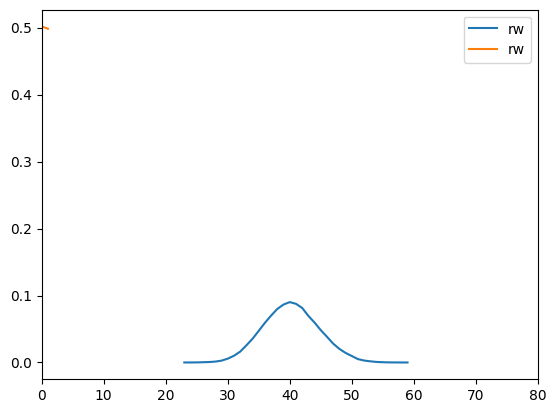

In [ ]:
m = np.unique(num_in_recp_B,return_counts=True)
ax.plot(m[0],m[1]/sum(m[1]),label='rw')
ax.set_xlim([0,workers])
ax.legend()
fig  # This line will cause the figure to be displayed

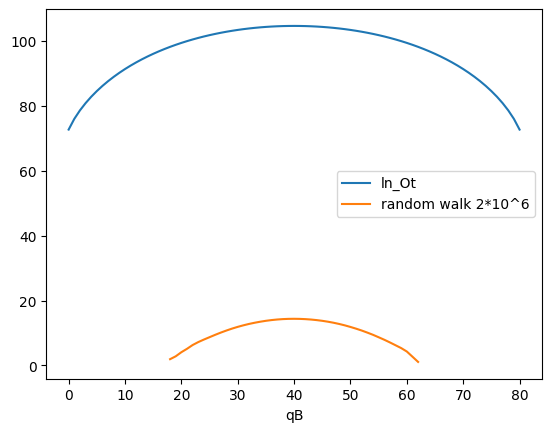

In [ ]:
m = np.unique(num_in_recp_B,return_counts=True)
ax2.plot(m[0],np.log(m[1]),label='random walk 2*10^6');
#ax2.xlim([0,workers])
ax2.legend()
fig2

In [ ]:
rw_macrostatecounts = pd.DataFrame(m).T

AttributeError: 'tuple' object has no attribute 'T'

In [ ]:
rw_macrostatecounts['S'] = np.log(rw_macrostatecounts[1])

In [ ]:
rw_macrostatecounts.columns = ['q','O','S']

In [ ]:
rw_macrostatecounts

,q,O,S
0,18,7,1.945910
1,19,17,2.833213
2,20,60,4.094345
3,21,171,5.141664
4,22,549,6.308098
5,23,1362,7.216709
6,24,2964,7.994295
7,25,6156,8.725182
8,26,12752,9.453443
9,27,25431,10.143724


In [ ]:
rw_macrostatecounts['T'] = 2/(rw_macrostatecounts['S'].diff().fillna(0) - rw_macrostatecounts['S'].diff(periods=-1).fillna(0))

In [ ]:
 rw_macrostatecounts['C'] = 2/(rw_macrostatecounts['T'].diff().fillna(0) - rw_macrostatecounts['T'].diff(periods=-1).fillna(0))/workers

<Axes: xlabel='T'>

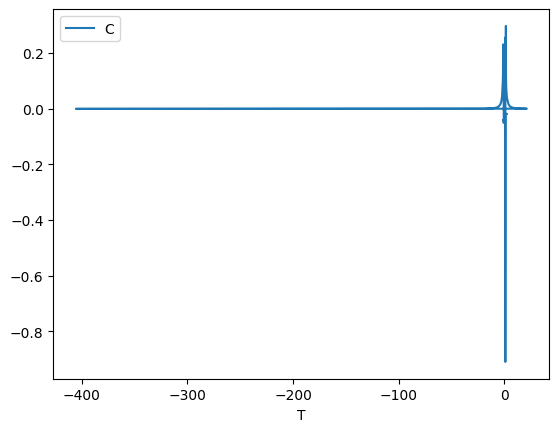

In [ ]:
rw_macrostatecounts.plot(x='T',y='C')

In [ ]:
stat_macrostates['SB'] = np.log(stat_macrostates['OB'])

In [ ]:
stat_macrostates['T'] = 2/(stat_macrostates['SB'].diff().fillna(0) - stat_macrostates['SB'].diff(periods=-1).fillna(0))

In [ ]:
stat_macrostates['C'] = 2/(stat_macrostates['T'].diff().fillna(0) - stat_macrostates['T'].diff(periods=-1).fillna(0))/40

<Axes: xlabel='T'>

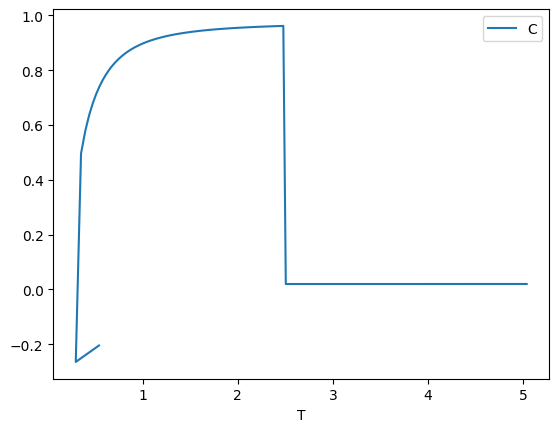

In [ ]:
stat_macrostates.plot(x='T',y='C')

<ipython-input-171-664ea83503dc>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/np.gradient( stat_macrostates['ln_Ot'] ))


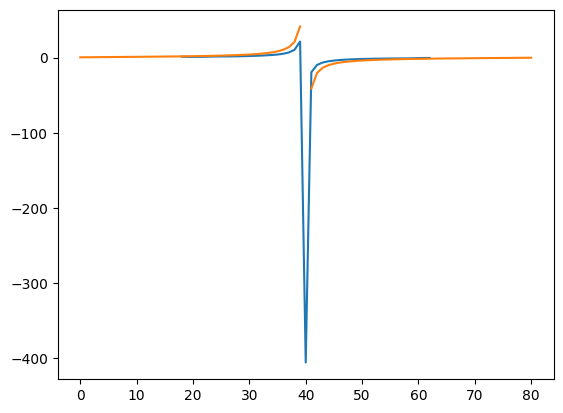

In [ ]:
plt.plot(m[0],1/np.gradient(np.log(m[1])))
#plt.ylim([-20,20])
plt.plot(1/np.gradient( stat_macrostates['ln_Ot'] ))

##theory


In [ ]:
import pandas as pd

In [ ]:
from scipy.special import comb

In [ ]:
def multiplicity(q, N):
    """

    Args:
      q:
      N:

    Returns:

    """
    # Calculate the multiplicity for an Einstein solid with N oscillators and q quanta
    return comb(q + N - 1, q)

In [ ]:
workers = 80
qB = np.arange(0,workers+1)
stat_macrostates = pd.DataFrame(qB,columns=['qB'])
jB = 40
jA = 40

In [ ]:
1/np.sqrt(jB+jA)

0.11180339887498948

In [ ]:
stat_macrostates['OB'] = stat_macrostates.apply(lambda x: multiplicity(x['qB'],jB), axis=1)
stat_macrostates['qA'] = (workers - stat_macrostates['qB']).astype(int)
stat_macrostates['OA'] = stat_macrostates['qA'].apply(lambda x: multiplicity(x,jA))
stat_macrostates['Ot'] = stat_macrostates['OA'] * stat_macrostates['OB']
stat_macrostates['Ot_norm'] = stat_macrostates['Ot'] / stat_macrostates['Ot'].max()
stat_macrostates['Ot_prob'] = stat_macrostates['Ot'] / stat_macrostates['Ot'].sum()

In [ ]:
 2.355 *stat_macrostates['Ot_prob'].std()

0.04731688670139488

In [ ]:
stat_macrostates['Ot_norm^2'] = stat_macrostates['Ot_norm']**2

In [ ]:
stat_macrostates.plot(x='qB',y='Ot_prob',ax=ax)
ax.set_xlim([0,workers])
ax.legend()
fig  # This line will cause the figure to be displayed

In [ ]:
stat_macrostates['ln_Ot_norm'] = np.log(stat_macrostates['Ot_norm'] )
stat_macrostates['ln_Ot_prob'] = np.log(stat_macrostates['Ot_prob'] )
stat_macrostates['ln_Ot'] = np.log(stat_macrostates['Ot'] )

In [ ]:
fig2, ax2 = plt.subplots()  # Create a figure and an axes.

In [ ]:
stat_macrostates.plot(x='qB',y='ln_Ot',ax=ax2)



<Axes: xlabel='qB'>

with reflections, weird kinks

In [ ]:
stat_macrostates.plot(x='qB',y='ln_Ot_norm')
plt.plot(macrostates2[0],np.log(macrostates2[1]/np.max(macrostates2[1])),label='random walk 1',color='green');
plt.xlim([0,workers])
plt.legend()

#time distribution

In [ ]:
import random

def simulate(num_workers, num_commodities, num_time_units):
    # Initialize the commodities and workers
    commodities = [0 for _ in range(num_commodities)]
    workers = [random.randint(0, num_commodities - 1) for _ in range(num_workers)]

    # Each worker contributes their time units
    for _ in range(num_time_units):
        for i in range(num_workers):
            # Each worker has a 1/3 chance of staying, 2/3 chance of moving
            if random.random() < 2/3:
                workers[i] = random.randint(0, num_commodities - 1)
            commodities[workers[i]] += 1

    return commodities

# Run the simulation
num_workers = 100
num_commodities = 5
num_time_units = 8
result = simulate(num_workers, num_commodities, num_time_units)

print("Time units per commodity:", result)


In [ ]:
from numba import jit
import numpy as np

@jit(nopython=True)
def simulate(num_workers, num_positions, production_time_unit_duration):
    # Initialize the positions and workers
    positions = np.zeros(num_positions)
    workers = np.random.uniform(0.5, 1.5, num_workers)
    worker_positions = np.random.randint(0, num_positions, num_workers)

    # Each worker contributes their time units
    for _ in range(production_time_unit_duration):
        for i in range(num_workers):
            # Each worker has a 50% chance of moving forward or backwards
            if np.random.random() < 0.5:
                move = 1 if np.random.random() < 0.5 else -1  # Replaced np.random.choice([-1, 1]) with a conditional expression
                worker_positions[i] = (worker_positions[i] + move) % num_positions
            # If the worker is at a station (even position), they contribute their time units
            if worker_positions[i] % 2 == 0:
                positions[worker_positions[i]] += workers[i]

    # Convert the time units to commodities
    commodities = positions[::2]  # Only even positions are stations

    return commodities

In [ ]:
# Run the simulation
num_workers = 100000
num_stations = 1
production_time_unit_duration = 8
result = simulate(num_workers, num_stations, production_time_unit_duration)

print("Commodities per receptacle:", result)

In [ ]:
num_workers = 100000000
np.mean(np.random.uniform(0.5, 1.5, num_workers))*production_time_unit_duration*num_workers